<a href="https://colab.research.google.com/github/Lememski/IAT360-Final-Project/blob/main/computervisionproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Image Brain MRI Classification using YOLO <b> </h1></center>

This code was primarily referenced from this Kaggle code:
**https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn**

**Pre-processing**

Importing all required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

Adding the google colab file to get the dataset into our notebook

Import the google drive: https://drive.google.com/drive/folders/1q4gX01EEeXj1qo-daa3uRjRfxSKtgMQT?usp=drive_link

/content/drive/MyDrive/IAT 360 Project1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<center><h1> <b> Image Preperation <b> </h1></center>

make labels for the 4 tumor classes

In [3]:
labels = ['glioma','meningioma','notumor','pituitary']

load MRI data from directories from train and test and resized for uniformity which is crucial for CNN.

We combine the the training and test and append to the same list. So the images (xtrain) and labels (yTrain) is stored in numby arrays to make them easy to manipulate with ML frameworks. They also allow for faster processing!

The ytrain array provides the ground truth enabling the supervised learning for the images (xtrain)


In [5]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/IAT 360 Final Project/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/IAT 360 Final Project/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:06<00:00, 46.24it/s] 


display the first image found for each label in a dataset (y_train contains the labels for X_train images). It places one image per subplot, showing the first sample image from each label. The images are shown in a 1x4 grid, and each image is labeled with its corresponding class.

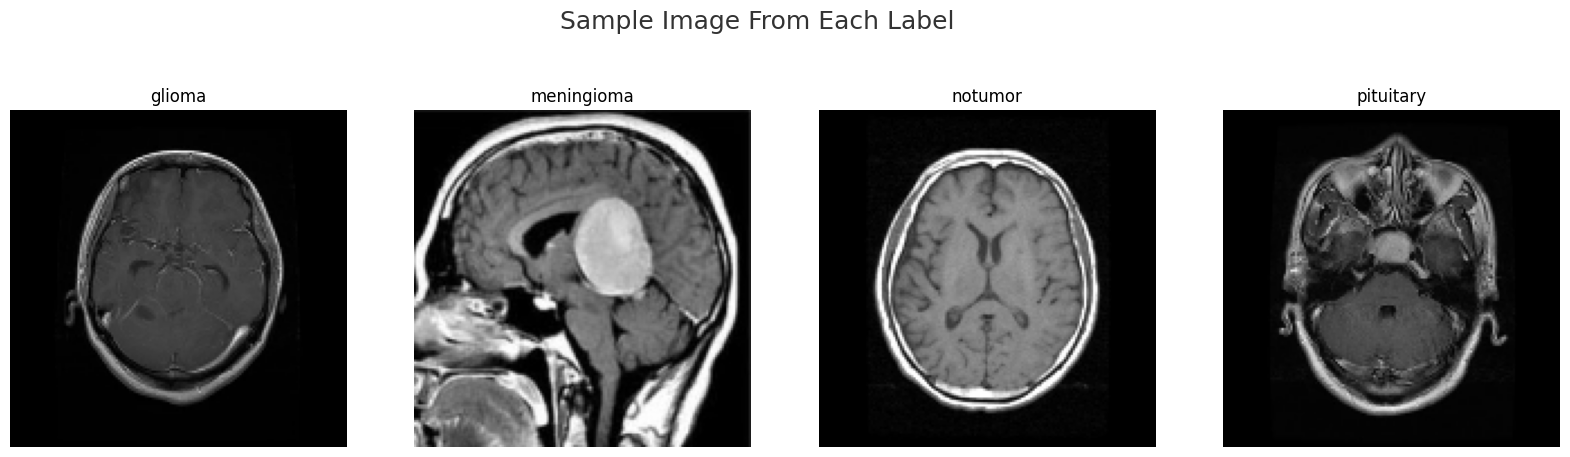

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label', size = 18, y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

ensure randomness in the dataset while maintaining the correct label-pairings

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

return the dimension of the array
1. number of images - make sure you are taking from the correct dataset
2. height (px)
3. width (px)
4. number of colour channels (RGB) (3)

In [8]:
X_train.shape

(7083, 150, 150, 3)

In [9]:
y_train.shape

(7083,)

Dividing the dataset into Training and Testing sets

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing One Hot Encoding on the labels after converting it into numerical values
prepare labels for proper use

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

<center><h1> <b> Transfer Learning <b> </h1></center>

In this notebook, we will be using the **EfficientNetB0 model** which will use the weights from the ImageNet dataset.We chose this one (as well as the referecned model code) due to its efficiency and performance. It is the smallest and most computationally efficient model in the EfficientNet family (see citations in report)

In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


1. GlobalAveragePooling2D:
This layer reduces the spatial dimensions of the feature maps by taking the average value of each feature map. It helps reduce computational load and prevents overfitting by summarizing the features efficiently, unlike MaxPooling which uses the maximum value.

2. Dropout:
Dropout randomly deactivates a percentage of neurons during training, preventing the model from over-relying on specific neurons. This promotes independence among neurons, improving generalization and reducing the risk of overfitting.

3. Dense:
The Dense layer is the output layer that classifies the input into one of the possible classes. It uses the Softmax activation function to output probabilities, with the class having the highest probability being selected as the prediction.





In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

information about the model for parameter reference and our learning purposes:

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 150, 150, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 150, 150, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 150, 150, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 151, 151, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 75, 75, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 75, 75, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 75, 75, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 75, 75, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 75, 75, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 75, 75, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

checking for best hyperparamters.

Despite getting an error based on our reserach and it still syaing adam after 2 epochs, we chose that hyperparameter to train the final model.

In [15]:
!pip install keras-tuner
import keras_tuner as kt


def model_builder(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),  # Flatten the image to a 1D vector
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')  # Adjust output for your classes
    ])

    # Hyperparameter for optimizer
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'RMSprop', 'Adagrad', 'Adam'])

    model.compile(optimizer=hp_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=2)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The best optimizer is: {best_hps.get('optimizer')}")

Trial 2 Complete [00h 00m 05s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 15s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
Adagrad           |Adam              |optimizer
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4594 - loss: 762.6216
Epoch 2/2
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6771 - loss: 64.8613


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/usr/local/lib/python3.10/dist-packages/kera

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 116, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/objective.py", line 59, in get_value
    return logs[self.name]
KeyError: 'val_accuracy'


Compile the model


In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
# Logs the training process for visualization to track loss, accuracy, and training rates
tensorboard = TensorBoard(log_dir = 'logs')
# save model during training with best preformance
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
# adjust the learning rate dynamically during training
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

<center><h1> <b> Training the Model <b> </h1></center>

**We will begin hyperparameter training here**

We are fitting the model to the EfficientNetB0 model hyperparameters:

X_train | the inputted training data for our image

y_train | labels for the images



---



validation_split=0.1 | fraction of training data that will be set aside for validation and evaluate its preformance. 0.1 = 10%

epochs | started with 12. The amount of times the dataset is passed through the model

verbose | amount of information being printed during training, the progress bar for each epoch and current epoch number
*   verbose=0: No output.
*   verbose=1: Progress bar with basic information. (what we have)
*   verbose=2: One line per epoch.

batch_size | samples that will be processed together before the model's internal weights are updated


---



**callbacks**=[tensorboard, checkpoint, reduce_lr]:
*   tensorboard: visualize the training process
*   checkpoint: saves the model at the end of each epoch if it has improved
*   reduce_lr: dynamically adjusts the learning rate during training

patience=2 in this case due to using Keras and ReduceLROnPlateau callback

What our reduce_lr looks like:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_delta=0.001, mode='auto', verbose=1)







In [18]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8324 - loss: 0.4371
Epoch 1: val_accuracy improved from -inf to 0.92006, saving model to effnet.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 155s 428ms/step - accuracy: 0.8328 - loss: 0.4363 - val_accuracy: 0.9201 - val_loss: 0.2848 - learning_rate: 0.0010
Epoch 2/12
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9629 - loss: 0.1119
Epoch 2: val_accuracy improved from 0.92006 to 0.93887, saving model to effnet.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9629 - loss: 0.1118 - val_accuracy: 0.9389 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 3/12
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9793 - loss: 0.0645
Epoch 3: val_accuracy improved from 0.93887 to 0.94671, saving model to effnet.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9793 - loss: 0.0645 - val_accuracy: 0.9467 - val_loss: 0.2325 - learning_rate: 0.0010
Epoch 4/12
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - 

**Result of this training parameters:**

On the first epoch the training accuracy is 84.4% and a loss of 0.4221. It was better preformed on its validation accuracy at 88.56% and a loss of 0.4114.The model starts with a relatively low accuracy but improves during training, thus saved the data.

On the second epoch, the model trained significantly! Went up to 97% during training and 98.5% during validation!

By the fourth epoch the training reached 99.08%, but this lead to a decrease in validation accuracy (95%), so the model did not save.

By epoch five there was still no improvement, so the model reduced the learning rate by a factor of 3 (due to ReduceLROnPlateau callback being triggered due to stagnation)

this process repeats until epoch 9 whee the learning rate reduced by a factor of 3 again due to validation accuracy plateuing

Epoch 12 there is no further improvement in validation accuracy and training ends


**Visuals to show the process:**

See the accuracy plot

You can see how there was a big spike in the accuracy around epoch 3 but due to the training improving there is that drop of validation around epoch 4 we spoke of.

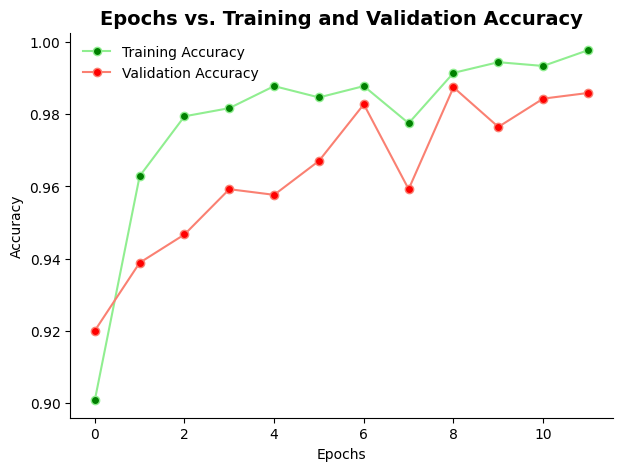

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'history' is already defined
epochs = [i for i in range(12)]
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Set up the plot for accuracy
fig, ax = plt.subplots(figsize=(7, 5))
sns.despine()

# Plot training accuracy and validation accuracy
ax.plot(epochs, train_acc, marker='o', markerfacecolor='green', color='lightgreen', label='Training Accuracy')
ax.plot(epochs, val_acc, marker='o', markerfacecolor='red', color='salmon', label='Validation Accuracy')

# Add labels, legend, and title
ax.legend(frameon=False)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Epochs vs. Training and Validation Accuracy', fontsize=14, fontweight='bold')

# Show the plot
plt.show()

Now we wanted to see the drop and raising of the loss. This will help determine hyperparameters to change to improve the models preformance.

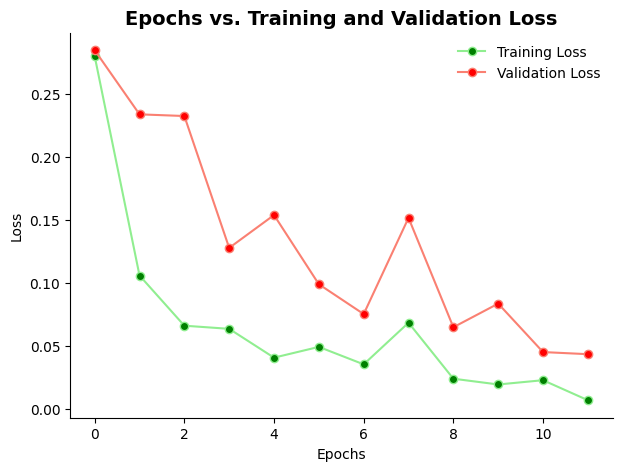

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'history' is already defined
epochs = [i for i in range(12)]
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Set up the plot for loss
fig, ax = plt.subplots(figsize=(7, 5))
sns.despine()

# Plot training loss and validation loss
ax.plot(epochs, train_loss, marker='o', markerfacecolor='green', color='lightgreen', label='Training Loss')
ax.plot(epochs, val_loss, marker='o', markerfacecolor='red', color='salmon', label='Validation Loss')

# Add labels, legend, and title
ax.legend(frameon=False)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Epochs vs. Training and Validation Loss', fontsize=14, fontweight='bold')

# Show the plot
plt.show()

**Hyperparameter pivot**

Due to the plateau around 8 epochs in these results we decided to try lowering the epochs to 10 for quicker experimentation.

As it only took 6 minutes to do the training, we increased the batch size to  make the training more stable with the lower amount of epochs to 16.

We also decided to play around with the reduce_lr callback- specically the patience so it will reduce the LR after 2 epochs if there are no improvements since we are doing less epochs now.

In [21]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_delta=0.001,
    mode='auto',
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    verbose=1,
    batch_size=16,
    callbacks=[tensorboard, checkpoint, reduce_lr]
)

Epoch 1/10
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9949 - loss: 0.0129
Epoch 1: val_accuracy did not improve from 0.98746
359/359 ━━━━━━━━━━━━━━━━━━━━ 76s 100ms/step - accuracy: 0.9949 - loss: 0.0129 - val_accuracy: 0.9875 - val_loss: 0.0417 - learning_rate: 3.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9983 - loss: 0.0067
Epoch 2: val_accuracy improved from 0.98746 to 0.98903, saving model to effnet.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9890 - val_loss: 0.0459 - learning_rate: 3.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9943 - loss: 0.0170
Epoch 3: val_accuracy did not improve from 0.98903
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9943 - loss: 0.0170 - val_accuracy: 0.9875 - val_loss: 0.0360 - learning_rate: 3.0000e-04
Epoch 4/10
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9985 - loss: 0.0065
Epoch 4: val_accuracy d

**Comparison of results with new parameters vs previous results**

The differences are accuracy, learning rate adjustments, and training time.

*with the new parameters*
*   Training Accuracy started at 99.49% and stabilized at 99.89% by Epoch 10
*   Validation Accuracy reached a maximum of 99.06% and plateaued after Epoch 5
*   Learning Rate started lower than the previous results (2.7e-5) and gradually decreased over time
*   Training time for each epoch was consistently shorter than the initial run

The new hyperparameters (particularly the learning rate and batch size) appear to make the model converge more quickly while providing solid results. However, while the model reaches a high training accuracy quickly, the validation **accuracy plateaued at 99.06%**, which suggests there may be room for further improvement by tweaking the learning rate, increasing epochs, or using additional techniques like data augmentation, early stopping, or a learning rate warm-up.

**This was not as good as the first run**

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_delta=0.001,
    mode='auto',
    verbose=1
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=4,  # Wait for 4 epochs with no improvement in validation accuracy
    restore_best_weights=True,  # Restore the model with the best validation accuracy
    verbose=1
)

# Updated training with more epochs and larger batch size
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,  # Increase to 20 epochs for a better chance to reach optimal accuracy
    verbose=1,
    batch_size=32,  # Increase batch size for more stability during training
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stopping]
)

Epoch 1/20
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.9332e-04
Epoch 1: val_accuracy did not improve from 0.99060
180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 1.0000 - loss: 1.9354e-04 - val_accuracy: 0.9890 - val_loss: 0.0419 - learning_rate: 3.7500e-05
Epoch 2/20
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.1865e-04
Epoch 2: val_accuracy did not improve from 0.99060
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 1.0000 - loss: 2.1811e-04 - val_accuracy: 0.9890 - val_loss: 0.0401 - learning_rate: 3.7500e-05
Epoch 3/20
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.1357e-04
Epoch 3: val_accuracy did not improve from 0.99060

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 1.0000 - loss: 1.1433e-04 - val_accuracy: 0.9890 - val_loss: 0.0400 - learning_rate: 3.7500e-05
Epoch 4/20
179/180 ━━━━━━━━━━━━━━━━━━━━ 0s 

**Results**

The model starts off with an accuracy of 1.0000 on the training data and a loss of 1.9332e-04, indicating that the model is able to fit the training data almost perfectly from the beginning. However, the validation accuracy remains lower at 0.9890, which suggests **the model is overfitting**.

During the second epoch accuracy remains very high (close to 1.0000) on the training data, which suggests that the model is memorizing the data rather than generalizing well and the validation shows no improvement.

After Epoch 5, the early stopping callback is triggered due to the lack of improvement in the validation accuracy over a set number of epochs (patience).

<center><h1> <b> The first model parameters is what we will go with <b> </h1></center>

<center><h1> <b> Prediction <b> </h1></center>

[add explaination for code below]

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step


In [24]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       175
           1       1.00      0.97      0.98       154
           2       1.00      1.00      1.00       214
           3       0.98      1.00      0.99       166

    accuracy                           0.99       709
   macro avg       0.99      0.99      0.99       709
weighted avg       0.99      0.99      0.99       709



**Confusion Matrix**

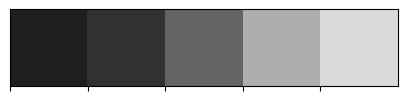

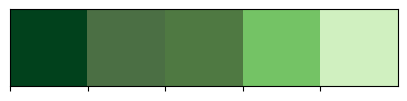

In [28]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)


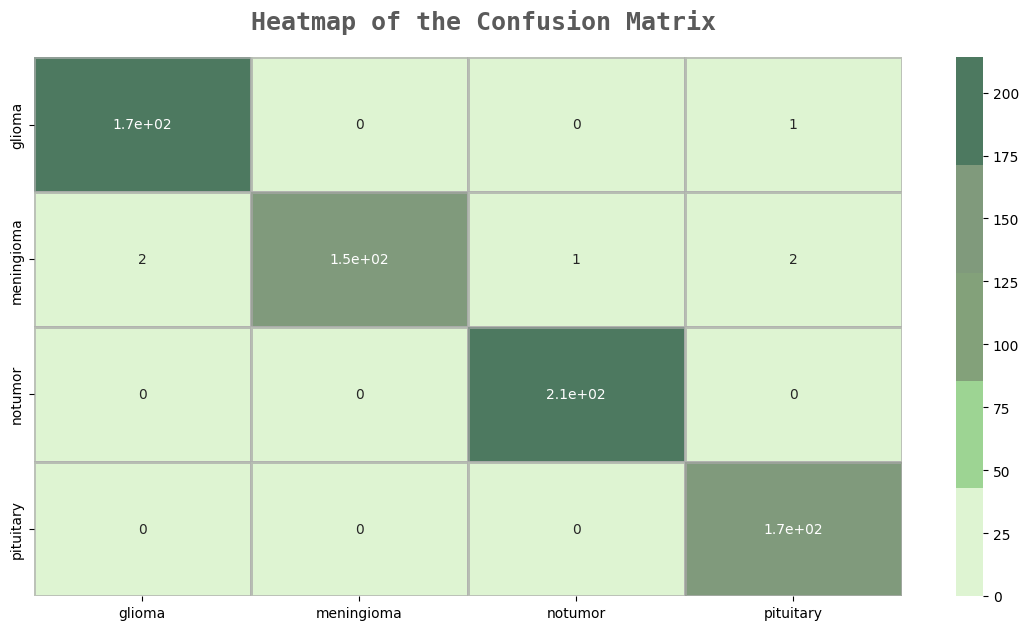

In [29]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()